# Speech Emotion Recognition model



## Dependencies



> Better use %pip instead on !pip on Jupyter Notebook, or create your own venv and kernel (!pip in Colab).



In [ ]:
!pip install librosa
!pip install tensorflow==2.6.0
!pip install pandas
!pip install tqdm
!pip install scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import librosa
import matplotlib.pyplot as plt
import sklearn
from tqdm import tqdm

## Data preparation

Copy and unzip the files to colab to optimize I/O operations (running from Drive is very slow).


> If you have the dataset in local, just create a folder in Colab's FS and upload it unzipped.


> If working from local (Jupyter Notebook), skip this step.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir /content/dataset
!unzip /content/drive/MyDrive/audios.zip -d /content/dataset

### Load CREMA-D dataset

In [ ]:
#CREMA-D DATASET

EMOTIONS = {'ANG': 'anger', 'HAP': 'happiness', 'DIS': 'disgust', 'FEA': 'fear', 'SAD': 'sadness', 'NEU': 'neutral'} # map codes to labels
crema_d = '/content/dataset/AudioWAV/'

file_emotion = {} # dict of key=filepath, value=emotion

for filepath in os.listdir(crema_d):
    path = crema_d + filepath
    file_emotion[path] = EMOTIONS[filepath.split('_')[2]] # filename: '1001_DFA_ANG_XX.wav' -> filepath.split('_')[2] = 'ANG' 

### Load RAVDESS dataset

In [ ]:
#RAVDESS DATASET

ravdess = '/content/dataset/ravdess/'
RAVDESS_EMOTIONS = {1: 'neutral', 2: 'neutral', 3: 'happiness', 4: 'sadness', 5: 'anger', 6: 'fear', 7: 'disgust', 8: 'surprise'} # map codes to labels (1, 2 both map to neutral)

for actor in os.listdir(ravdess):
    path = ravdess + actor
    for files in os.listdir(path):
        emotion = RAVDESS_EMOTIONS[int(files.split('-')[2])] # filename: '03-01-01-01-01-01-01.wav' -> filepath.split('_')[2] = '01' -> neutral
        path_new = path + '/' + files
        file_emotion[path_new] = emotion

### Merge datasets in a Pandas Dataframe

In [ ]:
import pandas as pd

dataset = pd.DataFrame(file_emotion.items(), columns=['path', 'emotion'])
pd.set_option('max_colwidth', 100)
dataset.tail(10)

,path,emotion
8872,/content/dataset/ravdess/Actor_04/03-01-08-02-02-02-04.wav,surprise
8873,/content/dataset/ravdess/Actor_04/03-01-06-01-02-02-04.wav,fear
8874,/content/dataset/ravdess/Actor_04/03-01-06-02-02-01-04.wav,fear
8875,/content/dataset/ravdess/Actor_04/03-01-04-02-01-02-04.wav,sadness
8876,/content/dataset/ravdess/Actor_04/03-01-02-01-02-02-04.wav,neutral
8877,/content/dataset/ravdess/Actor_04/03-01-02-02-02-01-04.wav,neutral
8878,/content/dataset/ravdess/Actor_04/03-01-05-01-02-02-04.wav,anger
8879,/content/dataset/ravdess/Actor_04/03-01-07-02-01-01-04.wav,disgust
8880,/content/dataset/ravdess/Actor_04/03-01-05-01-02-01-04.wav,anger
8881,/content/dataset/ravdess/Actor_04/03-01-04-01-01-01-04.wav,sadness


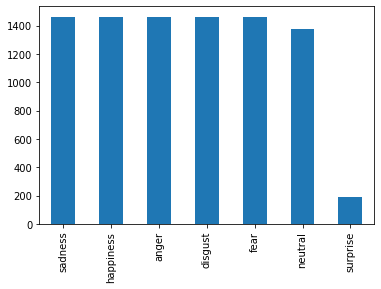

In [ ]:
pd.value_counts(dataset['emotion']).plot.bar()

In [ ]:
dataset['emotion'].count()

8882

### Test librosa functions on data samples

(50334,)
22050


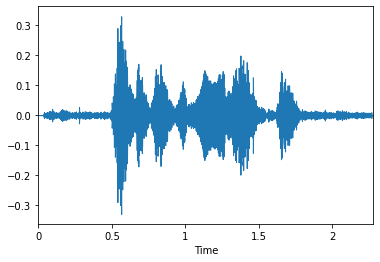

In [ ]:
import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt

sample = dataset.iloc[5, 0]
audio, sr = librosa.load(sample)
librosa.display.waveplot(audio, sr=sr)

print(audio.shape)
print(sr)
ipd.Audio(sample)

In [ ]:
#trim silence
yt, index = librosa.effects.trim(audio, top_db=30, frame_length=256, hop_length=64)
librosa.display.waveplot(yt, sr=sr)
ipd.Audio(yt, rate=sr)

#### Sound transformations for Data Augmentation

In [ ]:
def add_noise(audio):
  noise = 0.04*np.random.uniform()*np.amax(audio)
  audio = audio + (noise * np.random.normal(size=audio.shape[0]))
  return audio

def add_stretch(audio):
    return librosa.effects.time_stretch(audio, rate=0.8)

def add_pitch(audio, sr):
  return librosa.effects.pitch_shift(audio, sr=sr, n_steps=1.5)

In [ ]:
# testing noise transformation

noisy_audio = add_noise(audio)
librosa.display.waveplot(noisy_audio, sr=sr)
ipd.Audio(noisy_audio, rate=sr)

In [ ]:
# testing stretch transformation

stretch_audio = add_stretch(audio)
librosa.display.waveplot(stretch_audio, sr=sr)
ipd.Audio(stretch_audio, rate=sr)

In [ ]:
# testing pitch transformation

pitch_audio = add_pitch(audio, sr)
librosa.display.waveplot(pitch_audio, sr=sr)
ipd.Audio(pitch_audio, rate=sr)

### Check if GPU is available for training in Tensorflow

In [ ]:
#initialize colab GPU (or local GPU)
import tensorflow as tf

device_name = tf.test.gpu_device_name() # if GPU exists it returns its name, if not, it returns an empty string
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Building dataset for training



> Extracting the MFCC features from every audio sample and appending it to the dataset along with its corresponding label.



> ⚠ This step might take several minutes and it might consume high RAM memory and CPU.



In [ ]:
import numpy as np
from tqdm import tqdm

n_mfcc = 30
sampling_rate = 44100
audio_duration = 2.0

input_len = sampling_rate * audio_duration

X = np.empty(shape=(dataset.shape[0], n_mfcc, 173)) # shape is (num_samples, n_mfcc, sequence_length)
Y = []

for i, (file, emotion) in tqdm(enumerate(zip(dataset['path'], dataset['emotion']))):
    data, sr = librosa.load(file, sr = sampling_rate,  res_type='kaiser_fast', duration= audio_duration, offset=0.5) # load audio file with fixed length (2 seconds)

    if len(data) > input_len:
            max_offset = len(data) - input_len
            offset = np.random.randint(max_offset)
            data = data[offset:(input_len + offset)]
    else:
        if input_len > len(data):
            max_offset = input_len - len(data)
            offset = np.random.randint(max_offset)
        else:
            offset = 0
        data = np.pad(data, (offset, int(input_len) - len(data) - offset), 'constant')
    
    mfcc = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n_mfcc)
    X[i] = mfcc
    Y.append(emotion)

8882it [07:33, 19.60it/s]


In [ ]:
# load X and Y if previously saved to save time

X = np.load('/content/drive/MyDrive/X.npy')
Y = np.load('/content/drive/MyDrive/Y.npy')

#### Save the intermediate arrays to avoid generating new ones in every run of the notebook

In [ ]:
np.save('/content/drive/MyDrive/X.npy', X)
np.save('/content/drive/MyDrive/Y.npy', Y)

#### Transforming target labels to one-hot encoded vectors

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

lb = LabelEncoder()
Y_trans = to_categorical(lb.fit_transform(Y))

print(X.shape)
print(Y_trans.shape)

(8882, 30, 173)
(8882, 7)


#### Saving the LabelEncoder object for later use

In [ ]:
import pickle

filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

#### Applying data augmentation (noise on the training set)

In [ ]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

n_mfcc = 30
sampling_rate = 44100
audio_duration = 2.0

input_len = sampling_rate * audio_duration

# we take a little portion of the dataset to apply noise on it (20% of samples)
_, file_aug, _, emo_aug = train_test_split(dataset['path'], dataset['emotion'], test_size=0.2, random_state=0, shuffle = True)

X_aug = np.empty(shape=(file_aug.shape[0], n_mfcc, 173)) #previously known
y_aug = []

for i, (file, emotion) in tqdm(enumerate(zip(file_aug, emo_aug))):
    
    data, sr = librosa.load(file, sr = sampling_rate, duration= audio_duration, offset=0.5)

    if len(data) > input_len:
            max_offset = len(data) - input_len
            offset = np.random.randint(max_offset)
            data = data[offset:(input_len + offset)]
    else:
        if input_len > len(data):
            max_offset = input_len - len(data)
            offset = np.random.randint(max_offset)
        else:
            offset = 0
        data = np.pad(data, (offset, int(input_len) - len(data) - offset), 'constant')
    
    noise_mfcc = librosa.feature.mfcc(add_noise(data), sr=sampling_rate, n_mfcc=n_mfcc)
    
    X_aug[i] = noise_mfcc
    y_aug.append(emotion)
  
y_augmented = to_categorical(lb.transform(y_aug))

1777it [05:48,  5.10it/s]


In [ ]:
# load arrays if previously saved to save time

X_aug = np.load('/content/drive/MyDrive/X_aug.npy')
y_augmented = np.load('/content/drive/MyDrive/Y_aug.npy')

#### Save the intermediate arrays to avoid generating new ones in every run of the notebook

In [ ]:
np.save('/content/drive/MyDrive/X_aug.npy', X_aug)
np.save('/content/drive/MyDrive/Y_aug.npy', y_augmented)

In [ ]:
print(X_aug.shape)
print(y_augmented.shape)
print(lb.inverse_transform(np.argmax(y_augmented[:5], axis=1)))

(1777, 30, 173)
(1777, 7)
['fear' 'fear' 'disgust' 'surprise' 'fear']


#### Splitting data, concatenating augmented samples to the training set and normalizing data on the training set

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, Y_trans, test_size=0.2, random_state=0, shuffle = True)

X_train = np.concatenate((X_train, X_aug), axis=0)
y_train = np.concatenate((y_train, y_augmented), axis=0)

print('After concatenating: ', X_train.shape)

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
min = np.min(X_train, axis=0)
max = np.max(X_train, axis=0)

# MinMax Scaling
#X_train = (X_train - min)/(max - min)
#X_test = (X_test - min)/(max - min)

# Normalizing
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

print('After expanding dims: ', X_train.shape)

After concatenating:  (8882, 30, 173)
After expanding dims:  (8882, 30, 173, 1)


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(lb.inverse_transform(np.argmax(y_train[:5], axis=1)))

(8882, 30, 173, 1)
(1777, 30, 173, 1)
(8882, 7)
(1777, 7)
['fear' 'neutral' 'fear' 'fear' 'disgust']


## Training the model

### Main model (chosen for the serverless deployment)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization, TimeDistributed, LSTM, GaussianNoise
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

# Build the model using the functional API
i = Input(X_train[0].shape)

x = Conv2D(64, (5, 5), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(128, (5, 5),  activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)
x = GaussianNoise(0.35)(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.1))(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(len(dataset['emotion'].unique()), activation='softmax')(x)

model = Model(i, x)
plot_model(model, to_file='modelA.png', show_shapes=True, show_dtype=True, rankdir="TB", expand_nested=False)

### Alternative model

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization, TimeDistributed, LSTM, GaussianNoise, LeakyReLU, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

# Build the model using the functional API
i = Input(shape= X_train[0].shape)

x = Conv2D(64, (5, 5), padding='same')(i)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x) #Activation('relu')(x) #
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(128, (5, 5), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x) #Activation('relu')(x) #
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x) #Activation('relu')(x) #
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x) #Activation('relu')(x) #
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)
x = GaussianNoise(0.35)(x)

x = Flatten()(x)
#x = Dropout(0.2)(x)
x = Dense(256, kernel_regularizer=l2(0.1))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x)
x = Dense(len(dataset['emotion'].unique()), activation='softmax')(x)

model = Model(i, x)
plot_model(model, to_file='modelB.png', show_shapes=True, show_dtype=True)

### Alternative Transfer Learning model (experimental)



> Based on the VGG16 model pre-trained on the ImageNet dataset.



In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization, TimeDistributed, LSTM, GaussianNoise, LeakyReLU, Activation

X3_train = np.concatenate((X_train, X_train, X_train), axis=-1)
X3_test = np.concatenate((X_test, X_test, X_test), axis=-1)

base_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=X3_train[0].shape)
base_model.trainable = False

x = Flatten()(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256, kernel_regularizer=l2(0.1))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x)
x = Dense(len(dataset['emotion'].unique()), activation='softmax')(x)

model = Model(base_model.input, x)

### Compiling and fitting the model

In [ ]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from datetime import datetime

batch_size = 32
num_epochs = 100
num_train_steps = (len(X_train)// batch_size) * num_epochs

logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

lr_scheduler = PolynomialDecay( initial_learning_rate= 0.1, end_learning_rate=0.001, decay_steps=num_train_steps)

earlystop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=8, min_delta=0.02, verbose = 1)

tboard_cb = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                           histogram_freq = 1,
                                           profile_batch = '500,520')


opt = tf.keras.optimizers.Adagrad(learning_rate=0.005, epsilon=1e-07) #tf.keras.optimizers.Adam(learning_rate = lr_scheduler) #
model.compile(optimizer = opt,
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'):
  r = model.fit(X_train, y_train, 
                validation_data=(X_test, y_test),
                batch_size=batch_size,
                callbacks=[tboard_cb], # the TensorBoard callback is used for profiling and it slows the process of training, remove if not useful.
                epochs = num_epochs)

Epoch 1/100
278/278 [==============================] - 30s 70ms/step - loss: 25.4115 - accuracy: 0.3203 - val_loss: 12.8992 - val_accuracy: 0.2223
Epoch 2/100
278/278 [==============================] - 20s 71ms/step - loss: 7.6153 - accuracy: 0.4044 - val_loss: 4.8048 - val_accuracy: 0.3849
Epoch 3/100
278/278 [==============================] - 17s 63ms/step - loss: 3.6061 - accuracy: 0.4395 - val_loss: 2.7490 - val_accuracy: 0.4451
Epoch 4/100
278/278 [==============================] - 17s 62ms/step - loss: 2.4371 - accuracy: 0.4590 - val_loss: 2.0803 - val_accuracy: 0.4789
Epoch 5/100
278/278 [==============================] - 17s 62ms/step - loss: 2.0088 - accuracy: 0.4757 - val_loss: 1.8290 - val_accuracy: 0.4896
Epoch 6/100
278/278 [==============================] - 17s 62ms/step - loss: 1.8026 - accuracy: 0.4952 - val_loss: 1.7014 - val_accuracy: 0.5177
Epoch 7/100
278/278 [==============================] - 17s 61ms/step - loss: 1.6940 - accuracy: 0.5098 - val_loss: 1.7243 - val_

## Evaluating the model

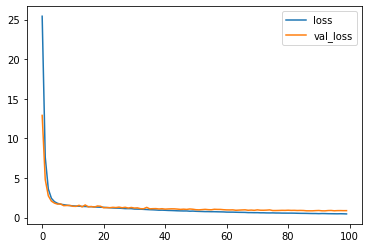

In [ ]:
import matplotlib.pyplot as plt

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
#plt.savefig('modelA_loss.png')

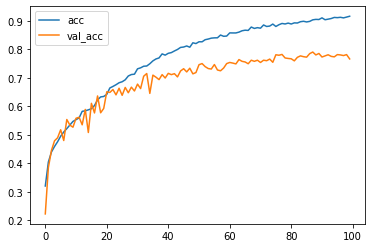

In [ ]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
#plt.savefig('modelA_acc.png')

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 173, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 30, 173, 64)       1664      
                                                                 
 batch_normalization (BatchN  (None, 30, 173, 64)      256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 86, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 86, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 86, 128)       204928

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

56/56 [==============================] - 1s 21ms/step - loss: 0.8804 - accuracy: 0.7665
accuracy: 76.65%


## Saving the model

In [ ]:
model_name = 'prototype2_ravdess.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

print(save_dir)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name)
model.save(model_path)

model_json = model.to_json()
with open("prototype2_ravdess.json", "w") as json_file:
    json_file.write(model_json)

/content/saved_models


## Loading the model

In [ ]:
from tensorflow.keras.models import model_from_json

json_file = open('prototype2_ravdess.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/prototype2_ravdess.h5")
loaded_model.summary()

# Keras optimizer
opt = tf.keras.optimizers.Adagrad(learning_rate=0.005, epsilon=1e-07) #Adam(learning_rate = lr_scheduler) #
loaded_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 173, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 30, 173, 64)       1664      
                                                                 
 batch_normalization (BatchN  (None, 30, 173, 64)      256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 86, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 86, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 86, 128)       204928

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


accuracy: 75.58%


In [ ]:
# another option without JSON

model = tf.keras.models.load_model('saved_models/prototype2_ravdess.h5')
model.summary()

opt = tf.keras.optimizers.Adagrad(learning_rate=0.005, epsilon=1e-07) #Adam(learning_rate = lr_scheduler) #
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

### Confusion matrix

In [ ]:
preds = model.predict(X_test, 
                      batch_size=32, 
                      verbose=1)

preds=preds.argmax(axis=1)
preds

56/56 [==============================] - 1s 16ms/step


array([5, 5, 1, ..., 4, 5, 0])

In [ ]:
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual= y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

finaldf = actual.join(preds)
finaldf.head()

,actualvalues,predictedvalues
0,fear,sadness
1,fear,sadness
2,disgust,disgust
3,surprise,surprise
4,fear,anger


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

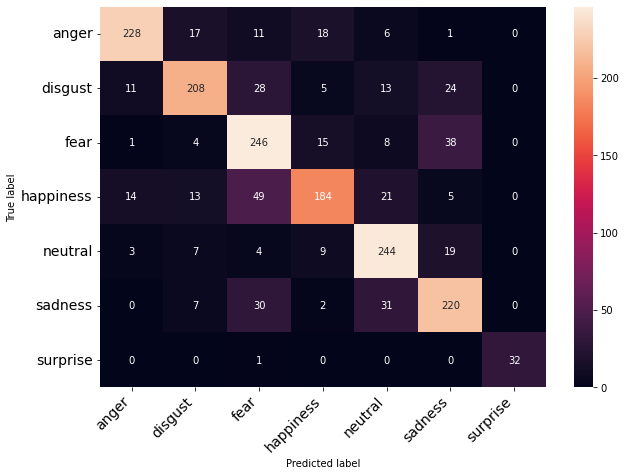

In [ ]:
from sklearn.metrics import confusion_matrix

classes = finaldf.actualvalues.unique()
classes.sort()    

# Print confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print_confusion_matrix(c, class_names = classes)

## Testing a sample audio

In [ ]:
sample_file = '/content/dataset/AudioWAV/1002_IWL_FEA_XX.wav'

n_mfcc = 30
sampling_rate = 44100
audio_duration = 2.0

input_len = sampling_rate * audio_duration

data, sr = librosa.load(sample_file, sr = 44100, duration= 2.0, offset=0.5)

if len(data) > input_len:
    max_offset = len(data) - input_len
    offset = np.random.randint(max_offset)
    data = data[offset:(input_len + offset)]
else:
    if input_len > len(data):
        max_offset = input_len - len(data)
        offset = np.random.randint(max_offset)
    else:
        offset = 0
    data = np.pad(data, (offset, int(input_len) - len(data) - offset), 'constant')

mfcc = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=30)
mfcc_std = (mfcc - mean) / std
mfcc_exp = np.expand_dims(mfcc_std, axis=(0, -1))
print(mfcc_exp.shape)

(1, 30, 173, 1)


In [ ]:
# get single prediction
result = np.argmax(loaded_model.predict(mfcc_exp), axis=1).astype(int).flatten()
print(result)
print(lb.inverse_transform(result))

[2]
['fear']


### Testing average time of each execution (histogram)

-------------
Mean:  49.067532840026615 ms
Std:  13.61644636124419 ms
Skewness:  8.496838935492407
-------------


Text(0, 0.5, 'Frequency')

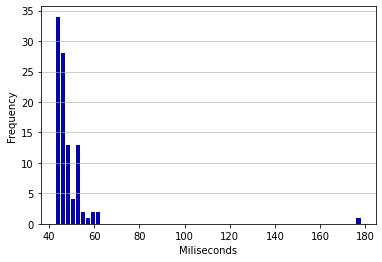

In [ ]:
# get gaussian distribution (WITHOUT PREPROCESSING)
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from time import perf_counter

model = tf.keras.models.load_model('saved_models/prototype2_ravdess.h5')

times = []
for i in range(100):
  start = perf_counter()
  model.predict(mfcc_exp)
  end = perf_counter()
  times.append(end - start)

times = np.array(times) * 1000  # miliseconds
mean = times.mean()
std = times.std()

print('-------------')
print('Mean: ', mean, 'ms')
print('Std: ', std, 'ms')
print('Skewness: ', stats.skew(times))
print('-------------')

n, bins, patches = plt.hist(x=times, bins='auto', color='#0504aa', rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Miliseconds')
plt.ylabel('Frequency')

#   skewness = 0 : normally distributed.
#   skewness > 0 : more weight in the left tail of the distribution.
#   skewness < 0 : more weight in the right tail of the distribution.

### Testing average time WITH PREPROCESSING of the data

In [ ]:
def preprocessing_sample():
  sample_file = '/content/dataset/AudioWAV/1002_IWL_FEA_XX.wav'

  n_mfcc = 30
  sampling_rate = 44100
  audio_duration = 2.0

  input_len = sampling_rate * audio_duration

  data, sr = librosa.load(sample_file, sr = 44100, duration= 2.0, offset=0.5)

  if len(data) > input_len:
      max_offset = len(data) - input_len
      offset = np.random.randint(max_offset)
      data = data[offset:(input_len + offset)]
  else:
      if input_len > len(data):
          max_offset = input_len - len(data)
          offset = np.random.randint(max_offset)
      else:
          offset = 0
      data = np.pad(data, (offset, int(input_len) - len(data) - offset), 'constant')

  mfcc = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=30)
  mfcc_std = (mfcc - mean) / std
  mfcc_exp = np.expand_dims(mfcc_std, axis=(0, -1))
  
  return mfcc_exp

-------------
Mean:  308.52456587996585 ms
Std:  133.89698532614779 ms
Skewness:  3.3552552286550505
-------------


Text(0, 0.5, 'Frequency')

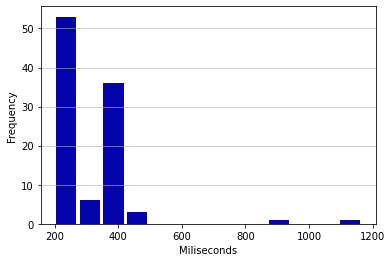

In [ ]:
# get gaussian distribution
import matplotlib.pyplot as plt
import scipy.stats as stats
from time import perf_counter

model = tf.keras.models.load_model('saved_models/prototype2_ravdess.h5')

times = []
for i in range(100):
  start = perf_counter()
  mfcc_exp = preprocessing_sample()
  model.predict(mfcc_exp)
  end = perf_counter()
  times.append(end - start)

times = np.array(times) * 1000  # miliseconds
mean = times.mean()
std = times.std()

print('-------------')
print('Mean: ', mean, 'ms')
print('Std: ', std, 'ms')
print('Skewness: ', stats.skew(times))
print('-------------')

n, bins, patches = plt.hist(x=times, bins='auto', color='#0504aa', rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Miliseconds')
plt.ylabel('Frequency')

#   skewness = 0 : normally distributed.
#   skewness > 0 : more weight in the left tail of the distribution.
#   skewness < 0 : more weight in the right tail of the distribution.

## Test training time

> Training with the TensorBoard callback needed beforehand to generate the logs

In [ ]:
!pip install -U tensorboard-plugin-profile

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=logs